<a href="https://colab.research.google.com/github/takaito1/EAS4821_S2024/blob/main/scripts/week9_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install cartopy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 47.1 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from scipy import stats
import cartopy.crs as ccrs
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# loading Nino3.4 index
nino34 = np.genfromtxt('/content/drive/MyDrive/nino34.txt')

In [21]:
# loading NAO index
nao = np.genfromtxt('/content/drive/MyDrive/NAO.txt',skip_header=1)
nao[:,0]

array([1950., 1951., 1952., 1953., 1954., 1955., 1956., 1957., 1958.,
       1959., 1960., 1961., 1962., 1963., 1964., 1965., 1966., 1967.,
       1968., 1969., 1970., 1971., 1972., 1973., 1974., 1975., 1976.,
       1977., 1978., 1979., 1980., 1981., 1982., 1983., 1984., 1985.,
       1986., 1987., 1988., 1989., 1990., 1991., 1992., 1993., 1994.,
       1995., 1996., 1997., 1998., 1999., 2000., 2001., 2002., 2003.,
       2004., 2005., 2006., 2007., 2008., 2009., 2010., 2011., 2012.,
       2013., 2014., 2015., 2016., 2017., 2018., 2019., 2020., 2021.,
       2022., 2023.])

In [4]:
# loading air temperature data
ds = xr.open_dataset('/content/drive/MyDrive/EAS2655_4821/air.2m.mon.mean.nc')

In [5]:
def calc_Neff(X,Y):
    # lag1-autocorrelation for X
    tmp1=X[:-1]
    tmp2=X[1:]
    c=np.cov(tmp1,tmp2)
    r1=c[0,1]/np.sqrt(c[0,0]*c[1,1])
    # lag1-autocorrelation for Y
    tmp1=Y[:-1]
    tmp2=Y[1:]
    c=np.cov(tmp1,tmp2)
    r2=c[0,1]/np.sqrt(c[0,0]*c[1,1])
    # calculate Neff
    N=np.size(X)
    Neff = N*(1-r1*r2)/(1+r1*r2)
    if Neff > N:
        Neff = N
    return Neff

In [6]:
# define a function to calculate regression / correlation coefficients
def regrcorr(X,Y,CL):
    alp = 1-CL/100
    c=np.cov(X,Y)
    a=c[0,1]/c[0,0]
    b=np.mean(Y)-a*np.mean(X)
    r=c[0,1]/np.sqrt(c[0,0]*c[1,1])
    Neff=calc_Neff(X,Y)
    MSE = np.sum(((a*X+b) - Y)**2)/(Neff-2)
    SEa = np.sqrt( MSE/np.sum((X-np.mean(X))**2) )
    SEr = np.sqrt( (1-r**2)/(Neff-2) )
    ta=np.abs(a)/SEa
    tr=np.abs(r)/SEr
    tcrit=stats.t.ppf(1-alp/2,Neff-2)
    if ta>tcrit:
        sig_a = 1
    else:
        sig_a = 0
    if tr>tcrit:
        sig_r = 1
    else:
        sig_r = 0
    output=np.array([a,b,r,Neff,SEa,SEr,sig_a,sig_r])
    return output

In [13]:
def regrcorr_latlon(X,Y,CL):
    # loop over long and lat
    Ndata = np.shape(Y)
    Nx = Ndata[2]
    Ny = Ndata[1]
    output = np.zeros((8,Ny,Nx))
    for nx in range(Nx):
        for ny in range(Ny):
            Ylocal=Y[:,ny,nx]
            output_local = regrcorr(X,Ylocal,CL)
            output[:,ny,nx]=output_local
    return output

(76,)

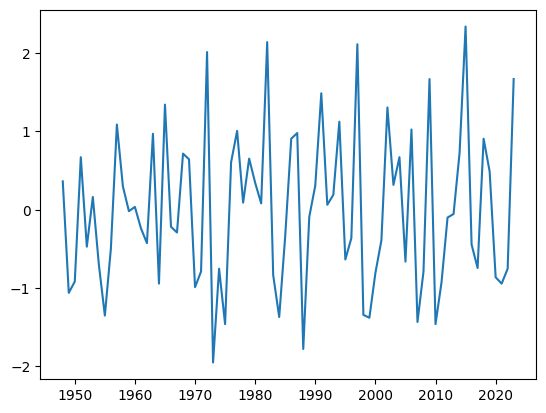

In [7]:
# preparing nino3.4 index data
#
year_nino = nino34[:,0]
dec_nino = nino34[:,12]
#plt.plot(year_nino,dec_nino)
after48 = (year_nino>=1948)
nino_0 = dec_nino[after48]
#plt.plot(year_nino[after48],nino_0)

# z-transform the nino34 index
nino_1 = (nino_0 - np.mean(nino_0))/np.std(nino_0)
plt.plot(year_nino[after48],nino_1)
nino_1.shape

(74,)

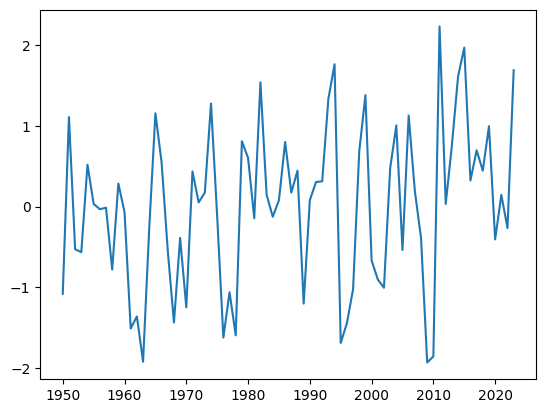

In [23]:
# preparing nino3.4 index data
#
year_nao = nao[:,0]
dec_nao = nao[:,12]
#plt.plot(year_nino,dec_nino)
#plt.plot(year_nino[after48],nino_0)

# z-transform the nino34 index
nao_1 = (dec_nao - np.mean(dec_nao))/np.std(dec_nao)
plt.plot(year_nao,nao_1)
nao_1.shape

In [25]:
## calling the regrcorr_latlon function
air = ds.air.sel(time=(ds.time.dt.month==12)).sel(time=slice('1950-01','2024-01')).to_numpy()-273.15
output = regrcorr_latlon(nao_1,air,95)

/usr/local/lib/python3.10/dist-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)


In [26]:
## xx and yy  are 2dim version of long and lat
xx,yy=np.meshgrid(ds.lon,ds.lat)

## select long and lat where regr coeff is significant
xxa=xx[output[6,:,:]==1]
yya=yy[output[6,:,:]==1]

## select long and lat where corr coeff is significant
xxr=xx[output[7,:,:]==1]
yyr=yy[output[7,:,:]==1]

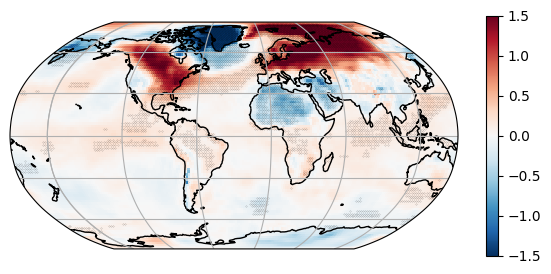

In [28]:
fig=plt.figure(figsize=(7,6))
ax=fig.add_axes([.1,.1,.8,.8],projection=ccrs.Robinson(central_longitude=-30))
im = ax.pcolormesh(ds.lon,ds.lat,output[0,:,:],cmap='RdBu_r',vmin=-1.5,vmax=1.5,
              transform=ccrs.PlateCarree())
ax.plot(xxa,yya,'.',transform=ccrs.PlateCarree(),
         markersize=.3,color='k',alpha=.5)
ax.coastlines()
ax.gridlines()
plt.colorbar(im,ax=ax,location='right',shrink=.5)

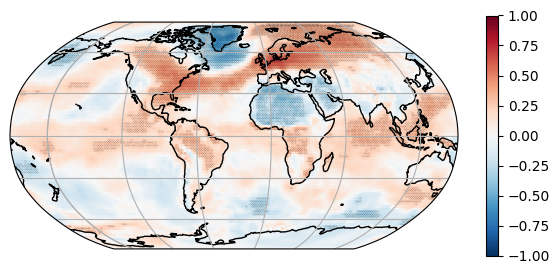

In [29]:
fig=plt.figure(figsize=(7,6))
ax=fig.add_axes([.1,.1,.8,.8],projection=ccrs.Robinson(central_longitude=-30))
im = ax.pcolormesh(ds.lon,ds.lat,output[2,:,:],cmap='RdBu_r',vmin=-1,vmax=1,
              transform=ccrs.PlateCarree())
ax.plot(xxr,yyr,'.',transform=ccrs.PlateCarree(),
         markersize=.3,color='k',alpha=.5)
ax.coastlines()
ax.gridlines()
plt.colorbar(im,ax=ax,location='right',shrink=.5)